In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad
import matplotlib.pyplot as plt
import os
import argparse
import yaml
from tqdm import tqdm
from glob import glob
import gc
from PIL import Image

In [2]:
# ========================================================================================
# UTILITY FUNCTIONS
# ========================================================================================

def Normalize_2D(x, eps=1e-8):
    return x * (x.square().mean(-1) + eps).rsqrt().view(-1, 1)

def PixelNorm(img, eps=1e-8):
    assert len(img.shape) == 4
    img = img - torch.mean(img, (2, 3), True)
    tmp = torch.mul(img, img)
    tmp = torch.rsqrt(torch.mean(tmp, (2, 3), True) + eps)
    return img * tmp

def Generate_map_channels(out_res, start_res=4, max_channels=512):
    base_channels = 16 * 1024
    map_channels = dict()
    k = start_res
    while k <= out_res:
        map_channels[k] = min(base_channels // k, max_channels)
        k *= 2
    return map_channels

In [3]:
# ========================================================================================
# GENERATOR COMPONENTS
# ========================================================================================

class Mapping(nn.Module):
    def __init__(self, z_dim: int, deep_mapping=8, normalize=True, eps=1e-8):
        super().__init__()
        self.dim = z_dim
        self.deep = deep_mapping
        self.normalize = normalize
        self.eps = eps
        self.blocks = []

        for i in range(self.deep):
            self.blocks.append(nn.Sequential(
                nn.Linear(self.dim, self.dim),
                nn.LeakyReLU(0.2),
            ))
            nn.init.xavier_normal_(self.blocks[-1][0].weight.data)
            nn.init.zeros_(self.blocks[-1][0].bias.data)

        self.blocks = nn.ModuleList(self.blocks)

    def forward(self, z):
        if self.normalize:
            z = Normalize_2D(z, self.eps)
        for block in self.blocks:
            z = block(z)
        return z

class Conv2Demod(nn.Module):
    def __init__(self, in_channels, out_channels, z_dim, kernel_size, stride=1, demod=True, eps=1e-8):
        super().__init__()
        assert stride == 1
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.demod = demod
        self.z_dim = z_dim
        self.eps = eps
        
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels, kernel_size, kernel_size)))
        self.A = nn.Linear(z_dim, in_channels)
        self.B = nn.Parameter(torch.zeros(out_channels))
        
        nn.init.xavier_normal_(self.weight)

    def forward(self, img, ws):
        b, c, kh, kw = img.shape
        styles = self.A(ws)
        
        w = self.weight.unsqueeze(0)
        w = w * styles.reshape(b, 1, -1, 1, 1)
        dcoefs = (w.square().sum(dim=[2,3,4]) + self.eps).rsqrt()
        w = w * dcoefs.reshape(b, -1, 1, 1, 1)
        
        img = img.reshape(1, -1, kh, kw)
        w = w.reshape(-1, self.in_channels, self.kernel_size, self.kernel_size)
        img = F.conv2d(img, weight=w, stride=self.stride, padding='same', groups=b)
        img = img.reshape(b, -1, kh, kw)
        
        noise = torch.randn(b, 1, kh, kw, device=img.device, dtype=img.dtype)
        img.add_(self.B.view(1, -1, 1, 1) * noise)
        
        return img

class BlockG(nn.Module):
    def __init__(self, res_in: int, res_out: int, in_channels: int, out_channels: int, 
                 rgb_channels: int, latent_size: int, is_last=False):
        super().__init__()
        assert res_out == res_in or res_out == 2 * res_in
        self.res_in = res_in
        self.res_out = res_out
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.latent_size = latent_size
        self.is_last = is_last

        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.Conv1 = Conv2Demod(in_channels, in_channels, latent_size, 3, 1)
        self.Conv2 = Conv2Demod(in_channels, out_channels, latent_size, 3, 1)
        self.Act = nn.LeakyReLU(0.2)
        
        if is_last:
            self.tRGB = nn.Conv2d(out_channels, rgb_channels, 1, 1)
            nn.init.xavier_normal_(self.tRGB.weight.data)
            nn.init.zeros_(self.tRGB.bias.data)
        else:
            self.tRGB = Conv2Demod(out_channels, rgb_channels, latent_size, 1, 1)

    def forward(self, x, rgb, w):
        assert len(x.shape) == 4

        if self.res_out == 2 * self.res_in:
            x = self.up_sample(x)
            rgb = self.up_sample(rgb)

        x = self.Conv1(x, w)
        x = self.Act(x)
        x = self.Conv2(x, w)
        x = self.Act(x)

        if self.is_last:
            rgb.add_(self.Act(self.tRGB(x)))
        else:
            rgb.add_(self.Act(self.tRGB(x, w)))
        return x, rgb

class Generator(nn.Module):
    def __init__(self, res: int, RGB=True, deep_mapping=8, start_res=4, 
                 max_channels=512, latent_size=512, normalize=True, eps=1e-8):
        super().__init__()
        assert 2 ** round(np.log2(res)) == res and res >= 4 and res <= 1024
        self.res = res
        self.out_channels = 3 if RGB else 1
        self.deep_mapping = deep_mapping
        self.latent_size = latent_size
        self.start_res = start_res
        self.eps = eps

        self.map_channels = Generate_map_channels(res, start_res, max_channels)
        self.mapping = Mapping(latent_size, deep_mapping, normalize, eps)
        self.const = nn.Parameter(torch.ones(max_channels, start_res, start_res))
        
        self.blocks = OrderedDict([
            (f'res {start_res}', BlockG(start_res, start_res, max_channels, 
                                       self.map_channels[start_res], self.out_channels, latent_size)),
        ])

        to_res = 2 * start_res
        while to_res <= res:
            cur_res = to_res // 2
            in_channels = self.map_channels[cur_res]
            out_channels = self.map_channels[to_res]
            is_last = to_res == res
            self.blocks[f'res {to_res}'] = BlockG(cur_res, to_res, in_channels, out_channels, 
                                                 self.out_channels, latent_size, is_last)
            to_res *= 2

        self.blocks = nn.ModuleDict(self.blocks)

    def forward(self, z):
        w = self.mapping(z)
        img = self.const.expand(w.size(0), -1, -1, -1)
        rgb = torch.zeros((w.size(0), self.out_channels, self.start_res, self.start_res), device=w.device)
        for block in self.blocks.values():
            img, rgb = block(img, rgb, w)
        return rgb

In [4]:
# ========================================================================================
# DISCRIMINATOR COMPONENTS
# ========================================================================================

class BlockD(nn.Module):
    def __init__(self, res_in: int, res_out: int, in_channels: int, out_channels: int):
        super().__init__()
        self.res_in = res_in
        self.res_out = res_out
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.Conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.Conv2 = nn.Conv2d(out_channels, out_channels, 3, 2, 1)
        self.Skip = nn.Conv2d(in_channels, out_channels, 3, 2, 1)
        self.Act = nn.LeakyReLU(0.2)
        
        nn.init.xavier_normal_(self.Conv1.weight.data)
        nn.init.zeros_(self.Conv1.bias.data)
        nn.init.xavier_normal_(self.Conv2.weight.data)
        nn.init.zeros_(self.Conv2.bias.data)
        nn.init.xavier_normal_(self.Skip.weight.data)
        nn.init.zeros_(self.Skip.bias.data)

    def forward(self, x):
        y = self.Skip(x)
        y = self.Act(y)
        
        x = self.Conv1(x)
        x = self.Act(x)
        x = self.Conv2(x)
        x = self.Act(x)
        
        return x + y

class Discriminator(nn.Module):
    def __init__(self, res, RGB=True, last_res=4, max_channels=512):
        super().__init__()
        assert 2 ** round(np.log2(res)) == res
        self.res = res
        self.in_channels = 3 if RGB else 1
        self.blocks = OrderedDict()
        self.map_channels = Generate_map_channels(res, last_res, max_channels)
        
        to_res = res // 2
        while to_res >= last_res:
            cur_res = 2 * to_res
            in_channels = self.map_channels[cur_res]
            out_channels = self.map_channels[to_res]
            self.blocks[f'res {cur_res}'] = BlockD(cur_res, to_res, in_channels, out_channels)
            to_res //= 2

        self.fRGB = nn.Conv2d(self.in_channels, self.map_channels[res], 1, 1)
        self.Linear = nn.Linear(self.map_channels[last_res] * last_res ** 2, 1)
        
        nn.init.xavier_normal_(self.Linear.weight.data)
        nn.init.zeros_(self.Linear.bias.data)
        nn.init.xavier_normal_(self.fRGB.weight.data)
        nn.init.zeros_(self.fRGB.bias.data)
        
        self.blocks = nn.ModuleDict(self.blocks)

    def forward(self, img):
        assert img.shape[1:] == (self.in_channels, self.res, self.res)
        
        img = self.fRGB(img)
        for block in self.blocks.values():
            img = block(img)
        return self.Linear(img.view(img.size(0), -1))

In [5]:
# ========================================================================================
# LOSS FUNCTIONS
# ========================================================================================

def r1loss(inputs, label=None):
    l = -1 if label else 1
    return F.softplus(l * inputs).mean()

def discriminator_loss(D, real_imgs, fake_imgs, lambda_gp):
    real_imgs.requires_grad = True
    real_outputs = D(real_imgs)
    d_real_loss = r1loss(real_outputs, True)
    
    grad_real = grad(outputs=real_outputs.sum(), inputs=real_imgs, create_graph=True)[0]
    grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
    grad_penalty = 0.5 * lambda_gp * grad_penalty
    D_x_loss = d_real_loss + grad_penalty
    
    fake_logits = D(fake_imgs)
    D_z_loss = r1loss(fake_logits, False)
    D_loss = D_x_loss + D_z_loss
    return D_loss

def generator_loss(logits_fake):
    loss = r1loss(logits_fake, True)
    return loss

# ========================================================================================
# DATASET
# ========================================================================================

class AnimeDataset(Dataset):
    def __init__(self, dataset_dir, resolution):
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        
        print("Loading Anime Dataset...")
        self.data = []
        image_extensions = ['*.png', '*.jpg', '*.jpeg']
        
        for ext in image_extensions:
            for image_path in glob(os.path.join(dataset_dir, ext)):
                try:
                    image = Image.open(image_path)
                    image = image.convert('RGB')
                    self.data.append(self.transform(image))
                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
        
        print(f"Loaded {len(self.data)} images")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [6]:
# ========================================================================================
# HISTORY TRACKING
# ========================================================================================

class History:
    def __init__(self):
        self.generator_loss = []
        self.discriminator_loss = []
        self.epochs = []

    def save_history(self, epoch, generator_loss, discriminator_loss):
        self.generator_loss.append(generator_loss.item() if torch.is_tensor(generator_loss) else generator_loss)
        self.discriminator_loss.append(discriminator_loss.item() if torch.is_tensor(discriminator_loss) else discriminator_loss)
        self.epochs.append(epoch)
        print(f'Epoch: {epoch}, Generator Loss: {self.generator_loss[-1]:.4f}, Discriminator Loss: {self.discriminator_loss[-1]:.4f}')

    def plot_images(self, images, epoch, image_dir, generate_no_image):
        # Denormalize images
        images = (images + 1) / 2
        images = torch.clamp(images, 0, 1)
        
        grid = torchvision.utils.make_grid(images, nrow=generate_no_image, padding=5)
        np_grid = grid.permute(1, 2, 0).numpy()
        
        plt.figure(figsize=(12, 12))
        plt.imshow(np_grid)
        plt.axis('off')
        plt.savefig(os.path.join(image_dir, f'images_{epoch}.png'), bbox_inches='tight', dpi=150)
        plt.close()

    def plot_loss(self, image_dir):
        plt.figure(figsize=(10, 6))
        plt.plot(self.epochs, self.generator_loss, label='Generator Loss', color='blue')
        plt.plot(self.epochs, self.discriminator_loss, label='Discriminator Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('GAN Loss Over Epochs')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(image_dir, 'loss.png'), bbox_inches='tight', dpi=150)
        plt.close()

# ========================================================================================
# TRAINER CLASS
# ========================================================================================

class Trainer:
    def __init__(self, config):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Generator
        self.generator = Generator(
            res=config['generator']['resolution'],
            latent_size=config['generator']['latent_size'],
            deep_mapping=config['generator']['deep_mapping']
        ).to(self.device)
        
        self.optim_G = getattr(torch.optim, config['generator']['optim'])(
            params=self.generator.parameters(),
            lr=config['generator']['learning_rate']
        )
        
        self.z_dim = config['generator']['latent_size']
        
        # Discriminator
        self.discriminator = Discriminator(config['discriminator']['resolution']).to(self.device)
        self.optim_D = getattr(torch.optim, config['discriminator']['optim'])(
            params=self.discriminator.parameters(),
            lr=config['discriminator']['learning_rate']
        )
        
        self.lambda_gp = config['discriminator']['lambda_gp']
        
        # Dataset
        dataset = AnimeDataset(config['dataset_dir'], config['image_size'])
        self.dataloader = DataLoader(
            dataset, 
            batch_size=config['batch_size'], 
            shuffle=True, 
            pin_memory=True, 
            drop_last=True,
            num_workers=2
        )
        
        # Training parameters
        self.start_epoch = 0
        self.epochs = config['epochs']
        self.batch_size = config['batch_size']
        self.history = History()
        self.weight_dir = config['weight_dir']
        self.images_dir = config['images_dir']
        self.save_frequency = config['save_frequency']
        self.generate_no_image = config['generate_no_image']
        
        # Fixed noise for consistent visualization
        self.Z = torch.randn((self.generate_no_image * self.generate_no_image, self.z_dim), device=self.device)
        
        # Create directories
        os.makedirs(self.weight_dir, exist_ok=True)
        os.makedirs(self.images_dir, exist_ok=True)
        
        # Load existing model if available
        if os.path.exists(os.path.join(self.weight_dir, 'training_state.pt')):
            self.load_model()

    def generate_images(self, count=1):
        z = torch.randn((count, self.z_dim), device=self.device)
        return self.generator(z)

    def train_generator(self, fake_images):
        logits_fake = self.discriminator(fake_images)
        return generator_loss(logits_fake)

    def train_discriminator(self, real_images, fake_images):
        return discriminator_loss(self.discriminator, real_images, fake_images, self.lambda_gp)

    def train(self):
        print("Training StyleGAN2")
        print(f"Generator parameters: {sum(p.numel() for p in self.generator.parameters()):,}")
        print(f"Discriminator parameters: {sum(p.numel() for p in self.discriminator.parameters()):,}")
        
        for epoch in range(self.start_epoch, self.epochs):
            g_losses, d_losses = [], []
            
            progress_bar = tqdm(self.dataloader, desc=f'Epoch {epoch+1}/{self.epochs}')
            for real_images in progress_bar:
                real_images = real_images.to(self.device)
                
                # Train Discriminator
                self.optim_D.zero_grad()
                fake_images = self.generate_images(self.batch_size).detach()
                d_loss = self.train_discriminator(real_images, fake_images)
                d_loss.backward()
                self.optim_D.step()
                d_losses.append(d_loss.item())
                
                # Train Generator
                self.optim_G.zero_grad()
                fake_images = self.generate_images(self.batch_size)
                g_loss = self.train_generator(fake_images)
                g_loss.backward()
                self.optim_G.step()
                g_losses.append(g_loss.item())
                
                # Update progress bar
                progress_bar.set_postfix({
                    'G_loss': f'{g_loss.item():.4f}',
                    'D_loss': f'{d_loss.item():.4f}'
                })
            
            # Save history
            avg_g_loss = sum(g_losses) / len(g_losses)
            avg_d_loss = sum(d_losses) / len(d_losses)
            self.history.save_history(epoch, avg_g_loss, avg_d_loss)
            
            # Save model and generate images
            if epoch % self.save_frequency == 0:
                self.save_model(epoch)
                with torch.no_grad():
                    sample_images = self.generator(self.Z).cpu()
                    self.history.plot_images(sample_images, epoch, self.images_dir, self.generate_no_image)
            
            # Memory cleanup
            gc.collect()
            torch.cuda.empty_cache()
        
        # Final loss plot
        self.history.plot_loss(self.images_dir)

    def save_model(self, epoch):
        # Remove old models to save space
        pretrained_models = glob(os.path.join(self.weight_dir, 'model_*.pt'))
        if len(pretrained_models) >= 5:
            earliest_model = min(pretrained_models, key=lambda x: int(x.split('_')[-1].split('.')[0]))
            os.remove(earliest_model)
        
        # Save generator only
        torch.save(self.generator.state_dict(), os.path.join(self.weight_dir, f'model_{epoch}.pt'))
        
        # Save full training state
        training_state = {
            'generator': self.generator.state_dict(),
            'optim_G': self.optim_G.state_dict(),
            'discriminator': self.discriminator.state_dict(),
            'optim_D': self.optim_D.state_dict(),
            'epoch': epoch,
            'history': self.history,
            'Z': self.Z
        }
        torch.save(training_state, os.path.join(self.weight_dir, 'training_state.pt'))

    def load_model(self):
        if not os.path.exists(os.path.join(self.weight_dir, 'training_state.pt')):
            return
        
        print("Resuming training from previous epoch")
        training_state = torch.load(os.path.join(self.weight_dir, 'training_state.pt'), map_location=self.device)
        
        self.generator.load_state_dict(training_state['generator'])
        self.optim_G.load_state_dict(training_state['optim_G'])
        self.discriminator.load_state_dict(training_state['discriminator'])
        self.optim_D.load_state_dict(training_state['optim_D'])
        self.start_epoch = training_state['epoch'] + 1
        self.history = training_state['history']
        self.Z = training_state['Z']

In [7]:
from glob import glob


# ========================================================================================
# CONFIGURATION AND MAIN FUNCTION
# ========================================================================================

# Default configuration
DEFAULT_CONFIG = {
    'generator': {
        'loss': 'r1',
        'learning_rate': 0.0001,
        'optim': 'RMSprop',
        'resolution': 64,
        'latent_size': 256,
        'deep_mapping': 4
    },
    'discriminator': {
        'loss': 'r1',
        'learning_rate': 0.0001,
        'lambda_gp': 10,
        'optim': 'RMSprop',
        'resolution': 64
    },
    'image_size': 64,
    'batch_size': 32,
    'epochs': 50,
    'dataset_dir': '/kaggle/input/anime-faces/data',  # Update this path
    'weight_dir': '/kaggle/working/',
    'save_frequency': 1,
    'generate_no_image': 6,
    'images_dir': 'generated_images'
}

def main():
    # For Kaggle, you can modify the config directly or load from a file
    config = DEFAULT_CONFIG.copy()
    
    # Adjust for Kaggle environment
    config['dataset_dir'] = '/kaggle/input/anime-faces/data'  # Update with your dataset path
    config['epochs'] = 30  # Reduced for faster training on Kaggle
    
    print("Starting StyleGAN2 Training")
    print("Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    trainer = Trainer(config)
    trainer.train()
    
    print("Training completed!")

if __name__ == '__main__':
    main()

Starting StyleGAN2 Training
Configuration:
  generator: {'loss': 'r1', 'learning_rate': 0.0001, 'optim': 'RMSprop', 'resolution': 64, 'latent_size': 256, 'deep_mapping': 4}
  discriminator: {'loss': 'r1', 'learning_rate': 0.0001, 'lambda_gp': 10, 'optim': 'RMSprop', 'resolution': 64}
  image_size: 64
  batch_size: 32
  epochs: 30
  dataset_dir: /kaggle/input/anime-faces/data
  weight_dir: /kaggle/working/
  save_frequency: 1
  generate_no_image: 6
  images_dir: generated_images
Using device: cuda
Loading Anime Dataset...
Loaded 21551 images
Training StyleGAN2
Generator parameters: 24,538,639
Discriminator parameters: 25,967,617


Epoch 1/30: 100%|██████████| 673/673 [20:54<00:00,  1.86s/it, G_loss=1.0991, D_loss=0.9111]   


Epoch: 0, Generator Loss: 4.9467, Discriminator Loss: 3.9887


Epoch 2/30: 100%|██████████| 673/673 [20:50<00:00,  1.86s/it, G_loss=1.6653, D_loss=1.0452]


Epoch: 1, Generator Loss: 1.4926, Discriminator Loss: 1.1350


Epoch 3/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.4149, D_loss=1.2411]


Epoch: 2, Generator Loss: 1.3046, Discriminator Loss: 1.2121


Epoch 4/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.1728, D_loss=1.1451]


Epoch: 3, Generator Loss: 1.3403, Discriminator Loss: 1.1668


Epoch 5/30: 100%|██████████| 673/673 [20:49<00:00,  1.86s/it, G_loss=0.4031, D_loss=1.6113]


Epoch: 4, Generator Loss: 1.2481, Discriminator Loss: 1.1899


Epoch 6/30: 100%|██████████| 673/673 [20:49<00:00,  1.86s/it, G_loss=1.2856, D_loss=1.3159]


Epoch: 5, Generator Loss: 1.1591, Discriminator Loss: 1.2179


Epoch 7/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.4019, D_loss=1.2223]


Epoch: 6, Generator Loss: 1.0986, Discriminator Loss: 1.2364


Epoch 8/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.4382, D_loss=1.1856]


Epoch: 7, Generator Loss: 1.0557, Discriminator Loss: 1.2519


Epoch 9/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.0817, D_loss=1.2264]


Epoch: 8, Generator Loss: 1.0214, Discriminator Loss: 1.2611


Epoch 10/30: 100%|██████████| 673/673 [20:52<00:00,  1.86s/it, G_loss=0.9066, D_loss=1.3220]


Epoch: 9, Generator Loss: 0.9974, Discriminator Loss: 1.2690


Epoch 11/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.2437, D_loss=1.2375]


Epoch: 10, Generator Loss: 0.9742, Discriminator Loss: 1.2746


Epoch 12/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.0840, D_loss=1.2828]


Epoch: 11, Generator Loss: 0.9520, Discriminator Loss: 1.2810


Epoch 13/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.8042, D_loss=1.2733]


Epoch: 12, Generator Loss: 0.9467, Discriminator Loss: 1.2828


Epoch 14/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.0177, D_loss=1.2576]


Epoch: 13, Generator Loss: 0.9310, Discriminator Loss: 1.2876


Epoch 15/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.9501, D_loss=1.2837]


Epoch: 14, Generator Loss: 0.9220, Discriminator Loss: 1.2893


Epoch 16/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.7503, D_loss=1.3013]


Epoch: 15, Generator Loss: 0.9174, Discriminator Loss: 1.2889


Epoch 17/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.9421, D_loss=1.2591]


Epoch: 16, Generator Loss: 0.9062, Discriminator Loss: 1.2916


Epoch 18/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.7791, D_loss=1.3161]


Epoch: 17, Generator Loss: 0.9046, Discriminator Loss: 1.2911


Epoch 19/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.7999, D_loss=1.2779]


Epoch: 18, Generator Loss: 0.9037, Discriminator Loss: 1.2901


Epoch 20/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.1571, D_loss=1.3151]


Epoch: 19, Generator Loss: 0.9033, Discriminator Loss: 1.2885


Epoch 21/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.8732, D_loss=1.2635]


Epoch: 20, Generator Loss: 0.9014, Discriminator Loss: 1.2867


Epoch 22/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.7504, D_loss=1.2593]


Epoch: 21, Generator Loss: 0.8988, Discriminator Loss: 1.2858


Epoch 23/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.6806, D_loss=1.2884]


Epoch: 22, Generator Loss: 0.9016, Discriminator Loss: 1.2842


Epoch 24/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.9392, D_loss=1.2834]


Epoch: 23, Generator Loss: 0.8991, Discriminator Loss: 1.2825


Epoch 25/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.9732, D_loss=1.3000]


Epoch: 24, Generator Loss: 0.9033, Discriminator Loss: 1.2784


Epoch 26/30: 100%|██████████| 673/673 [20:52<00:00,  1.86s/it, G_loss=0.6842, D_loss=1.3436]


Epoch: 25, Generator Loss: 0.9083, Discriminator Loss: 1.2742


Epoch 27/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.7767, D_loss=1.2521]


Epoch: 26, Generator Loss: 0.9092, Discriminator Loss: 1.2711


Epoch 28/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.9896, D_loss=1.2798]


Epoch: 27, Generator Loss: 0.9134, Discriminator Loss: 1.2671


Epoch 29/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=0.9845, D_loss=1.2283]


Epoch: 28, Generator Loss: 0.9132, Discriminator Loss: 1.2650


Epoch 30/30: 100%|██████████| 673/673 [20:51<00:00,  1.86s/it, G_loss=1.1776, D_loss=1.3338]


Epoch: 29, Generator Loss: 0.9211, Discriminator Loss: 1.2599
Training completed!


In [8]:
# ========================================================================================
# IMAGE GENERATION CLASS
# ========================================================================================

class ImageGenerator:
    def __init__(self, model_path, device='cuda'):
        """
        Initialize the image generator with a trained model
        
        IMPORTANT: Update these parameters to match your training configuration!
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # 🔥 IMPORTANT: Update these to match your training config
        self.resolution = 64      # Change this to your training resolution
        self.latent_size = 256    # Change this to your training latent_size  
        self.deep_mapping = 4     # Change this to your training deep_mapping
        
        # Load the generator
        self.generator = Generator(
            res=self.resolution,
            latent_size=self.latent_size,
            deep_mapping=self.deep_mapping
        ).to(self.device)
        
        # Load the trained weights
        if os.path.exists(model_path):
            print(f"Loading model from: {model_path}")
            self.generator.load_state_dict(torch.load(model_path, map_location=self.device))
            self.generator.eval()
            print("✅ Model loaded successfully!")
        else:
            raise FileNotFoundError(f"Model file not found: {model_path}")

    def generate_random_images(self, num_images=16, save_path=None, show_images=True):
        """Generate random images from the trained model"""
        print(f"🎨 Generating {num_images} random images...")
        
        with torch.no_grad():
            # Generate random latent vectors
            z = torch.randn(num_images, self.latent_size, device=self.device)
            
            # Generate images
            fake_images = self.generator(z)
            
            # Denormalize images from [-1, 1] to [0, 1]
            fake_images = (fake_images + 1) / 2
            fake_images = torch.clamp(fake_images, 0, 1)
            
            if show_images:
                self.display_images(fake_images, num_images)
            
            if save_path:
                self.save_images(fake_images, save_path, num_images)
            
            return fake_images

    def generate_interpolation(self, num_steps=10, save_path=None, show_images=True):
        """Generate smooth interpolation between two random faces"""
        print(f"🔄 Generating interpolation with {num_steps} steps...")
        
        with torch.no_grad():
            # Generate two random latent vectors
            z1 = torch.randn(1, self.latent_size, device=self.device)
            z2 = torch.randn(1, self.latent_size, device=self.device)
            
            # Create interpolation
            alphas = torch.linspace(0, 1, num_steps, device=self.device)
            interpolated_images = []
            
            for alpha in alphas:
                z_interp = (1 - alpha) * z1 + alpha * z2
                fake_image = self.generator(z_interp)
                fake_image = (fake_image + 1) / 2  # Denormalize
                fake_image = torch.clamp(fake_image, 0, 1)
                interpolated_images.append(fake_image)
            
            interpolated_images = torch.cat(interpolated_images, dim=0)
            
            if show_images:
                self.display_images(interpolated_images, num_steps, nrow=num_steps)
            
            if save_path:
                self.save_images(interpolated_images, save_path, num_steps, nrow=num_steps)
            
            return interpolated_images

    def display_images(self, images, num_images, nrow=None):
        """Display images in the notebook"""
        if nrow is None:
            nrow = int(np.sqrt(num_images))
        
        grid = torchvision.utils.make_grid(images.cpu(), nrow=nrow, padding=2)
        
        plt.figure(figsize=(12, 12))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title(f'Generated Images ({num_images} samples)')
        plt.show()

    def save_images(self, images, save_path, num_images, nrow=None):
        """Save images to file"""
        if nrow is None:
            nrow = int(np.sqrt(num_images))
        
        grid = torchvision.utils.make_grid(images.cpu(), nrow=nrow, padding=2)
        
        # Convert to PIL Image and save
        grid_np = (grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        pil_image = Image.fromarray(grid_np)
        pil_image.save(save_path)
        print(f"💾 Images saved to: {save_path}")

# ========================================================================================
# EASY-TO-USE FUNCTIONS
# ========================================================================================

def load_and_generate(model_path, num_images=16):
    """
    Load a trained model and generate images
    
    Args:
        model_path: Path to your .pt model file (e.g., 'saved_model/model_50.pt')
        num_images: Number of images to generate
    """
    try:
        generator = ImageGenerator(model_path)
        
        # Generate random images
        images = generator.generate_random_images(
            num_images=num_images,
            save_path=f'generated_random_{num_images}.png',
            show_images=True
        )
        
        # Generate interpolation
        interp_images = generator.generate_interpolation(
            num_steps=8,
            save_path='generated_interpolation.png',
            show_images=True
        )
        
        return generator, images, interp_images
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None, None, None

def quick_generate():
    """Find the latest model and generate images"""
    print("🔍 Looking for trained models...")
    
    # Find model files
    model_files = glob('saved_model/model_*.pt')
    if not model_files:
        print("❌ No model files found!")
        print("Available files in saved_model/:")
        if os.path.exists('saved_model'):
            print(os.listdir('saved_model'))
        else:
            print("saved_model/ directory doesn't exist")
        return None
    
    # Get the latest model
    latest_model = max(model_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    epoch = latest_model.split('_')[-1].split('.')[0]
    print(f"📁 Found model from epoch {epoch}: {latest_model}")
    
    # Generate images
    return load_and_generate(latest_model, num_images=16)

def generate_many_images(model_path, num_batches=5, images_per_batch=16):
    """Generate many images in batches"""
    generator = ImageGenerator(model_path)
    
    os.makedirs('generated_gallery', exist_ok=True)
    
    all_images = []
    for i in range(num_batches):
        print(f"Generating batch {i+1}/{num_batches}...")
        batch_images = generator.generate_random_images(
            num_images=images_per_batch,
            save_path=f'generated_gallery/batch_{i+1:02d}.png',
            show_images=False
        )
        all_images.append(batch_images)
    
    # Create a mega grid
    all_images = torch.cat(all_images, dim=0)
    mega_grid = torchvision.utils.make_grid(all_images.cpu(), nrow=8, padding=2)
    
    plt.figure(figsize=(16, 20))
    plt.imshow(mega_grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(f'Generated Gallery ({num_batches * images_per_batch} images)')
    plt.savefig('generated_gallery/mega_grid.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Generated {num_batches * images_per_batch} images in 'generated_gallery/'")

# ========================================================================================
# EXAMPLE USAGE
# ========================================================================================

print("🎨 StyleGAN2 Image Generator Ready!")
print("Usage examples:")
print("1. quick_generate()  # Auto-find latest model")
print("2. load_and_generate('saved_model/model_50.pt', 25)  # Specific model")
print("3. generate_many_images('saved_model/model_90.pt', 10, 16)  # Many images")

🎨 StyleGAN2 Image Generator Ready!
Usage examples:
1. quick_generate()  # Auto-find latest model
2. load_and_generate('saved_model/model_50.pt', 25)  # Specific model
3. generate_many_images('saved_model/model_90.pt', 10, 16)  # Many images


Using device: cuda
Loading model from: /kaggle/working/model_25.pt
✅ Model loaded successfully!
🎨 Generating 2 random images...


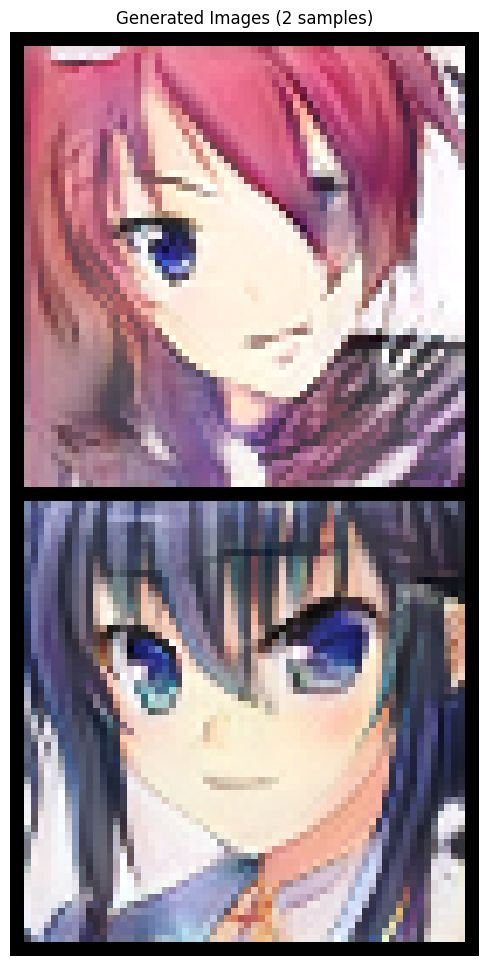

💾 Images saved to: generated_random_2.png
🔄 Generating interpolation with 8 steps...


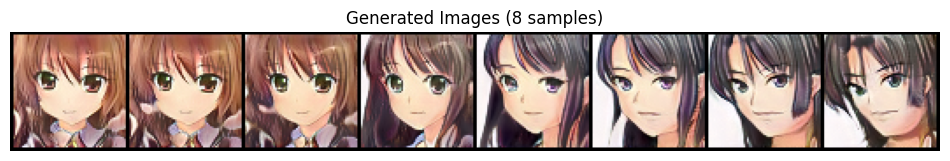

💾 Images saved to: generated_interpolation.png


(<__main__.ImageGenerator at 0x7b77b2ea7090>,
 tensor([[[[0.6971, 0.7786, 0.8057,  ..., 0.9773, 0.9658, 0.9818],
           [0.7566, 0.8092, 0.8362,  ..., 0.9572, 1.0000, 0.9965],
           [0.7247, 0.7833, 0.8340,  ..., 0.7642, 1.0000, 1.0000],
           ...,
           [0.7336, 0.7086, 0.7167,  ..., 0.3485, 0.6043, 0.5666],
           [0.7290, 0.7143, 0.7114,  ..., 0.3762, 0.6039, 0.2724],
           [0.7459, 0.7167, 0.7223,  ..., 0.5350, 0.4017, 0.2284]],
 
          [[0.4308, 0.4370, 0.4594,  ..., 0.9322, 0.9304, 0.9612],
           [0.3806, 0.3840, 0.4439,  ..., 0.9174, 0.9945, 0.9705],
           [0.3347, 0.3601, 0.4267,  ..., 0.7109, 0.9753, 0.9983],
           ...,
           [0.5636, 0.5201, 0.5394,  ..., 0.2905, 0.4759, 0.4329],
           [0.5466, 0.5312, 0.5528,  ..., 0.2716, 0.4480, 0.1721],
           [0.5973, 0.5083, 0.5704,  ..., 0.4634, 0.2689, 0.1445]],
 
          [[0.4985, 0.5109, 0.5379,  ..., 0.9300, 0.9383, 0.9583],
           [0.4867, 0.4938, 0.5398,  ..., 0.8

In [11]:
load_and_generate('/kaggle/working/model_25.pt', 2)